# Interpolating Temperature Using NOAA Sensors 

We will demonstrate using kriging to interpolate the average low temperature for the City of Chicago using NOAA sensors in a way that can be easily replicated for use with other data from other sensors including the Array of Things

## Load the required packages

In [1]:
library(sp)
library(rgdal)
library(rgeos)
library(leaflet)
library(raster)
library(gstat)
library(tmap)
library(tidyverse)

Warning message:
“package ‘rgdal’ was built under R version 3.4.4”rgdal: version: 1.3-4, (SVN revision 766)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.1.3, released 2017/20/01
 Path to GDAL shared files: /Users/isaackamber/Library/R/3.4/library/rgdal/gdal
 GDAL binary built with GEOS: FALSE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: /Users/isaackamber/Library/R/3.4/library/rgdal/proj
 Linking to sp version: 1.3-1 
rgeos version: 0.3-26, (SVN revision 560)
 GEOS runtime version: 3.6.1-CAPI-1.10.1 r0 
 Linking to sp version: 1.2-5 
 Polygon checking: TRUE 

Warning message:
“package ‘leaflet’ was built under R version 3.4.4”Warning message:
“package ‘gstat’ was built under R version 3.4.4”Warning message:
“package ‘tmap’ was built under R version 3.4.4”── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tib

## Read in the NOAA Data
Here we access NOAA sensor monthly high/low/average temperatures as well as rain/snowfall data and wind data.

In [2]:
#Read in the data
noaa.monthly <- read.csv("NOAA_master_monthly_final.csv")

#Preliminary look at data
head(noaa.monthly)

X,STATION,lat,long,elevation,X2012_5_precip_mo,X2012_5_temp_mo,X2012_5_temp_min_mo,X2012_5_temp_max_mo,X2012_5_wind_mo,⋯,X2018_4_temp_min_mo,X2018_4_temp_max_mo,X2018_4_wind_mo,X2018_4_snow_mo,X2018_5_precip_mo,X2018_5_temp_mo,X2018_5_temp_min_mo,X2018_5_temp_max_mo,X2018_5_wind_mo,X2018_5_snow_mo
1,US1ILCK0012,41.7550,-87.8173,188.1,0.13423077,NA,NA,NA,NA,⋯,NA,NA,NA,0.2833333,0.1654839,NA,NA,NA,NA,NA
2,US1ILCK0014,41.8008,-87.5903,182.9,0.11166667,NA,NA,NA,NA,⋯,NA,NA,NA,0.1038462,0.1577419,NA,NA,NA,NA,0
3,US1ILCK0023,41.8149,-87.8696,198.1,0.07870968,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,US1ILCK0032,41.9266,-87.6562,185.9,0.58666667,NA,NA,NA,NA,⋯,NA,NA,NA,NA,0.6280000,NA,NA,NA,NA,NA
5,US1ILCK0036,41.8860,-87.6210,191.1,0.06517241,NA,NA,NA,NA,⋯,NA,NA,NA,0.0000000,0.1608000,NA,NA,NA,NA,0
6,US1ILCK0042,42.0962,-87.8967,199.0,0.04482759,NA,NA,NA,NA,⋯,NA,NA,NA,0.1375000,0.2461290,NA,NA,NA,NA,0


From this first look at the data, we can tell a number of things.  Unfortuantely, this dataset is extremely incomplete and this will likely greatly affect our interpolation. Because we do not have access to monthly average temperatures, we will use monthly lows. Regardless, the same methodology will be used here as can be used with a future, more complete dataset. We do have the minimum and maximum monthly temperatures for a select few stations and for the purposes of this demonstration, we will use the monthly minimums. Specifically, we will interpolate for average monthly minimums over the Summer of 2015.

## Isolating the Desired Information

As previously stated, we wish to select the minimum monthly temperatures for the Summer of 2015

In [5]:
#Select minimum monthly temperatures
temp.monthly.min <- noaa.monthly %>%
    dplyr::select(contains("min_mo"))

In [45]:
#Isolate for Summer 2015
sum.mintemp.2015 <- temp.monthly.min %>%
  dplyr:: select(`X2015_6_temp_min_mo`:`X2015_8_temp_min_mo`)

Now let's turn the monthly readings to one average reading for the summer. 

In [46]:
#Get avg. low temp over Summer
sum.mintemp.2015 <- rowSums(sum.mintemp.2015, na.rm = TRUE) / 3

## Make our Data Spatial
Now that we have the low summer temperature data, let's reattach the coordinates of the sensors where these readings are coming from.

In [66]:
#Select sensor coordinates/other info
sensor.info <- noaa.monthly %>%
  dplyr::select(STATION:elevation)

#Combine the sensor info with the sensor readings
sensor.temp.min <- cbind(sensor.info, sum.mintemp.2015)
tail(sensor.temp.min) #Tail taken because first few dozen values all NA/0

,STATION,lat,long,elevation,sum.mintemp.2015
107,USC00114890,41.54220,-87.54160,189.0,0.00000
108,USC00115110,41.70910,-87.87610,217.9,60.51147
109,USC00116616,41.49470,-87.68020,216.4,60.31147
110,USW00004838,42.12083,-87.90472,193.9,60.24265
111,USW00014819,41.78611,-87.75222,186.5,64.64624
112,USW00094846,41.99500,-87.93360,201.8,61.01900


We obviously have a lot of NA readings to remove before we can interpolate anything, so that will be our next step.

In [67]:
#Remove the 0s because 0 from the previous line, the NAs are now 0s
sensor.temp.min[sensor.temp.min==0] <- NA
complete.temp.min <- na.omit(sensor.temp.min)

#Take another look
glimpse(complete.temp.min)

Observations: 9
Variables: 5
$ STATION          <fct> USC00110442, USC00111497, USC00111550, USC00111577...
$ lat              <dbl> 42.11530, 42.13980, 41.85580, 41.73720, 41.70910, ...
$ long             <dbl> -88.16390, -87.78540, -87.60940, -87.77750, -87.87...
$ elevation        <dbl> 266.7, 192.0, 177.7, 189.0, 217.9, 216.4, 193.9, 1...
$ sum.mintemp.2015 <dbl> 59.70072, 59.47706, 62.68244, 64.64624, 60.51147, ...


Even though there are fewer observations than we were hoping for, let's continue.

In [68]:
#Set lat/lon
coordinates(complete.temp.min) <- complete.temp.min[,c("long", "lat")]
#Set projection to WSG84
proj4string(complete.temp.min) <- CRS("+init=epsg:4326")

## Setting Up the Kriging Interpolation

Before we can run the interpolation, we want to have the Chicago map imported so that we will know where to predict the temperatures for geographically. Additionally, we need to generate a variogram of the data to visually assess whether/how to proceed.

In [86]:
#Import map of Chicago/Community Areas
chi.map <- readOGR("Chicago")

#Change projection to WSG84
chi.map <- spTransform(chi.map, CRS("+init=epsg:4326 +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84
+towgs84=0,0,0"))

OGR data source with driver: ESRI Shapefile 
Source: "/Users/isaackamber/Desktop/AoT/NOAA Meteorological Data/Chicago", layer: "Chicago"
with 77 features
It has 9 fields


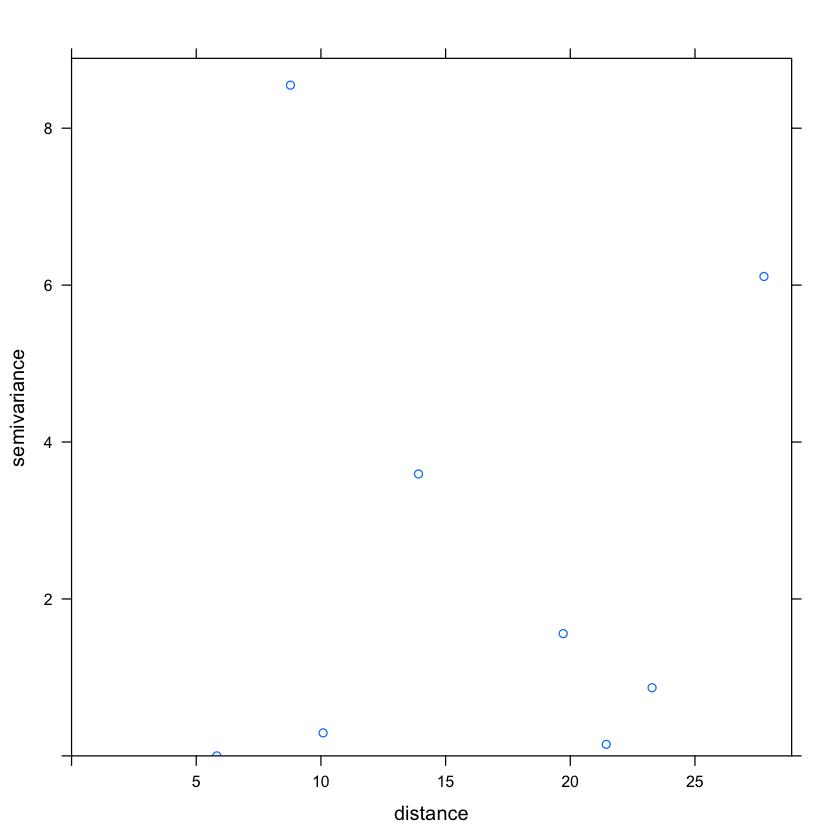

In [76]:
#Generate a variogram
sum.mintmp.vgm <- variogram(complete.temp.min$sum.mintemp.2015 ~ 1, complete.temp.min)
#Plot it
plot(sum.mintmp.vgm)

Typically, this variogram would indicate that kriging would not work for the given data both because of an insufficient number of readings (most sources recommend at least 30 different readings to generate an interpolation with kriging) as well as the shape of the variogram. Typically, we would expect/hope that the variogram initially increases rapidly and then levels off gradually until it flattens altogether. Even before fitting the model, we can see that this is not the case here at all. Nonetheless, we will continue for the purposes of establishing a framework. 

Warning message in fit.variogram(sum.mintmp.vgm, model = vgm("Sph")):
“singular model in variogram fit”

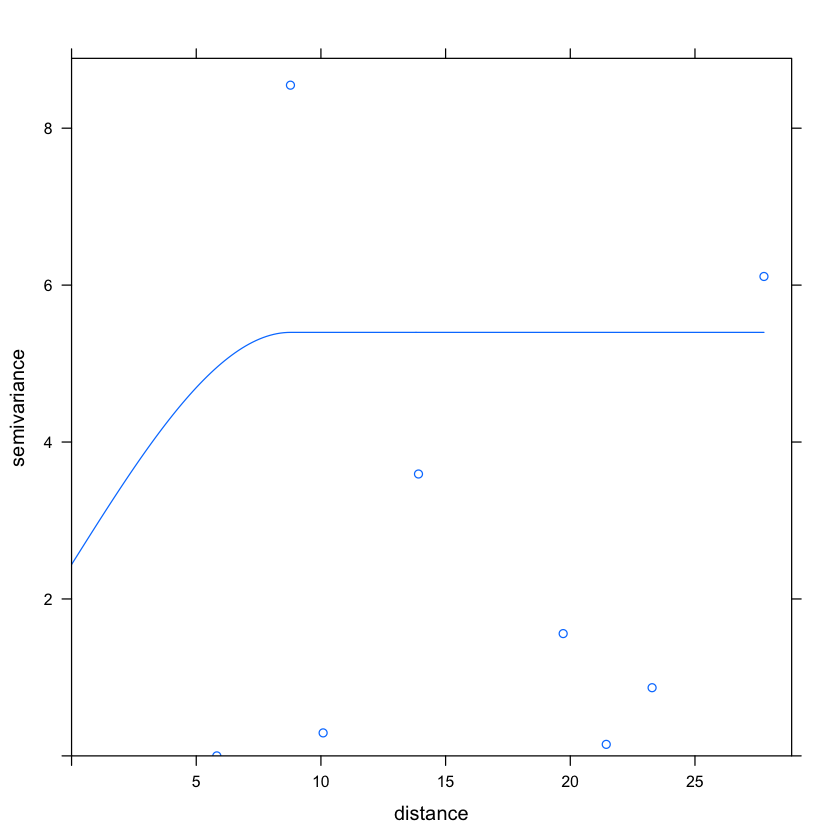

In [77]:
#Fitting a variogram model
sum.fit <- fit.variogram(sum.mintmp.vgm, model=vgm("Sph"))
#plot
plot(sum.mintmp.vgm, sum.fit)

In [78]:
#Generate prediction surface grid
pt2grid <- function(ptframe,n) {
  bb <- bbox(ptframe)  
  ptcrs <- proj4string(ptframe)  
  xrange <- abs(bb[1,1] - bb[1,2])  
  yrange <- abs(bb[2,1] - bb[2,2])  
  cs <- c(xrange/n,yrange/n)  
  cc <- bb[,1] + (cs/2)  
  dc <- c(n,n)  
  x1 <- GridTopology(cellcentre.offset=cc,cellsize=cs,cells.dim=dc)  
  x2 <- SpatialGrid(grid=x1,proj4string=CRS(ptcrs))
  return(x2)
}

#Create grid on Chicago
chi.grid <- pt2grid((chi.map),100)

## Krige and Visualize Interpolation

Now that everything is set up, we can krige and look at the results of our interpolation.

[using ordinary kriging]


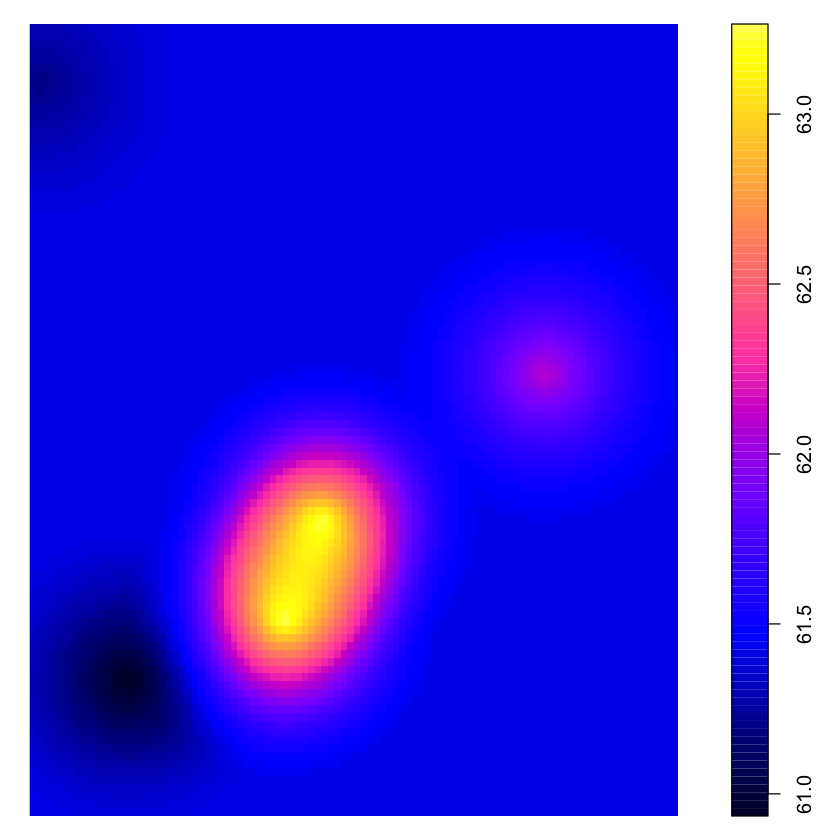

In [88]:
sum.kriged <- krige(complete.temp.min$sum.mintemp.2015 ~ 1, complete.temp.min, Chi.Grid, model = sum.fit)
plot(sum.kriged)

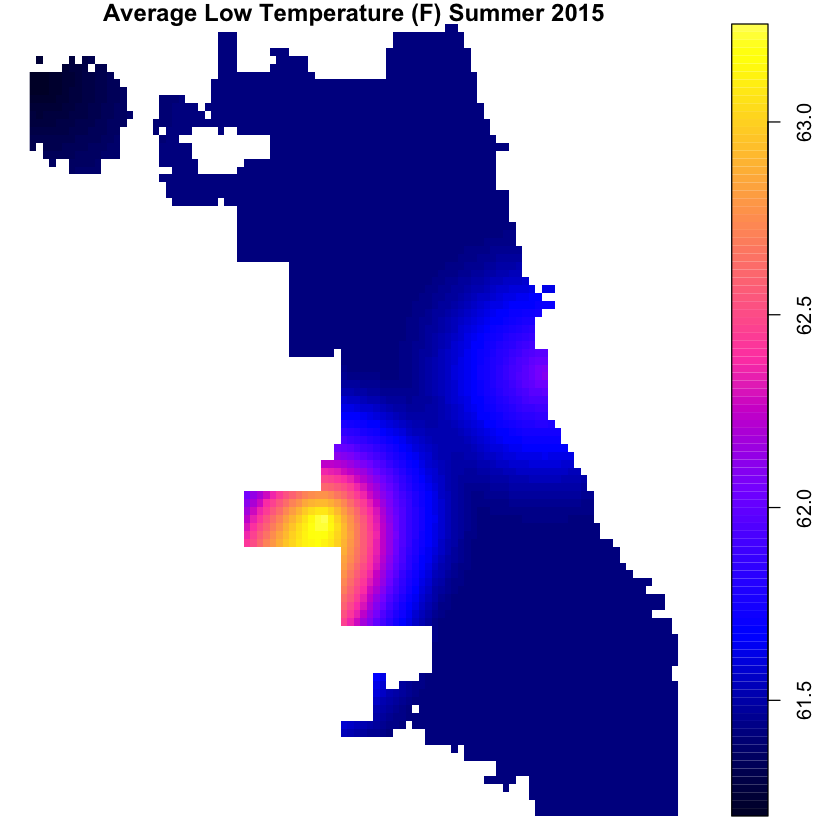

In [97]:
#Clip to city of Chicago
chi.sum.kriged <- sum.kriged[chi.map,]

#Visualize
plot(chi.sum.kriged)
title(main = "Average Low Temperature (F) Summer 2015", outer = FALSE)